In [42]:
import os, sys
sys.path.insert(0, '/home/jtorrenc/mvesc/ETL')
from mvesc_utility_functions import *
import numpy as np
import pandas as pd
import random
from functools import partial
import itertools
import pickle
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def color_gt(val,x=.5,c='blue',neg=True):
    """
    Colors values greater than x blue (or other provided color)
    
    :param float x: lower bound on colored values
    :param str c: color
    :param bool neg: if true, color negative values red
    :returns: css string to color values in dataframe
    :rtype: str
    """
    
    if val > x:
        color = c 
    elif val < 0:
        color = 'red' 
    else: color = 'black'
    return 'color: %s' % color

def table_exists(cursor, table, schema='clean'):
    """
    Checks to see if a table exists in the database
    
    :param pg.cursor cursor: 
    :param str table:
    :param str schema:
    :rtype: bool
    """
    cursor.execute("""                                                   
            select count(*) from information_schema.tables                       
            where table_schema = %s and table_name = %s
            """, [schema, table])
    return cursor.fetchall()[0][0]

# get filenames and predictions for best the best of each model

In [4]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        cursor.execute('select distinct model_name from model.reports')
        model_list = [m[0] for m in cursor.fetchall()]
        best = dict()
        for m in model_list:
            cursor.execute("""select filename from model.reports where model_name = %s
                            order by val_precision_10 desc limit 1; """, [m])
            best[m] = cursor.fetchall()[0][0]
    predictions = pd.DataFrame()
    for m, f in best.items():
        df = read_table_to_df(connection, f,columns = ['student_lookup','predicted_score'],
                                          schema='predictions',nrows=-1)
        df.set_index('student_lookup',inplace=True)
        df.columns = [m]
        predictions = pd.concat((predictions,df), axis=1, join='inner')


# Prediction Rank Correlation

In [5]:
spearman_pred = predictions.corr('spearman')
spearman_pred.style.applymap(partial(color_gt,x=.75))

# Get feature scores for the best of each model and feature set

In [7]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        cursor.execute('select distinct model_name from model.reports')
        model_list = [m[0] for m in cursor.fetchall()]
        cursor.execute('select distinct feature_categories from model.reports')
        feature_list = [f[0] for f in cursor.fetchall()]
        for f in feature_list:  #this won't work anymore when there are other combinations of features
            if ',' in f:
                feature_list.remove(f)
                if 'all' not in feature_list:
                    feature_list.append('all')
        best = dict()
        features = dict()
        spearman = dict()
        for f in feature_list:
            best[f] = dict()
            for m in model_list:
                if f != 'all':
                    cursor.execute("""select filename from model.reports 
                                    where model_name = %s
                                    and feature_categories = %s
                                    and feature_grades = '5, 6, 7, 8, 9'
                                    order by val_precision_10 desc limit 1; """, [m,f])
                else:
                    cursor.execute("""select filename from model.reports 
                                    where model_name = '{}'
                                    and feature_categories like '%,%'
                                    and feature_grades = '5, 6, 7, 8, 9'
                                    order by val_precision_10 desc limit 1; """.format(m))
                filename = cursor.fetchall()
                best[f][m] = filename[0][0]
            temp = pd.DataFrame()
            for m, file in best[f].items():
                if table_exists(cursor, file, 'feature_scores'):
                    df = read_table_to_df(connection, file ,columns=['feature','importance'],
                                          schema='feature_scores',nrows = -1)
                    df.set_index('feature',inplace=True)
                    df.columns = [m]
                    temp = pd.concat((temp,df), axis=1, join='outer')
            features[f] = temp
            spearman[f] = temp.abs().corr('spearman')

In [55]:
features.keys()

dict_keys(['all', 'oaa_normalized', 'absence', 'snapshots', 'grades', 'mobility'])

In [56]:
best['mobility']

{'AB': 'param_set_453_AB_ht_4524',
 'DT': 'param_set_458_DT_ht_4571',
 'ET': 'param_set_453_ET_ht_4523',
 'GB': 'param_set_468_GB_ht_4676',
 'KNN': 'param_set_458_KNN_ht_4579',
 'NB': 'param_set_463_NB_ht_4627',
 'RF': 'param_set_463_RF_ht_4622',
 'SGD': 'param_set_453_SGD_ht_4528',
 'SVM': 'param_set_453_SVM_ht_4525',
 'logit': 'param_set_453_logit_ht_4520'}

# Feature Rank Correlation


In [10]:
features['absence'].sort_values('RF', ascending=False).head()

,DT,GB,SVM,ET,RF,logit,SGD,AB
absence_gr_9,0.365461,0.274791,-1.100454e-05,0.227521,0.262409,0.320554,11.096859,0.307806
absence_unexcused_gr_9,0.125251,0.111924,7.603053e-05,0.117829,0.123408,0.222767,-1.331735,0.227052
absence_gr_8,0.030070,0.083167,3.625080e-05,0.092063,0.092386,-0.112034,-2.360803,0.016190
absence_gr_7,0.124259,0.099750,-8.322230e-07,0.082687,0.091420,-0.058574,-4.616682,0.052900
absence_gr_6,0.127702,0.081279,8.483957e-06,0.079043,0.079172,-0.222509,-9.943623,0.052965


In [11]:
spearman['absence'].style.applymap(partial(color_gt,x=.7))

In [13]:
features['mobility'].sort_values('RF', ascending=False).head()

,DT,GB,SVM,ET,RF,logit,SGD,AB
n_records_to_gr_9,0.093123,0.111195,1.472111,0.091628,0.094446,1.389409,15.536911,0.143540
avg_district_change_to_gr_9,0.237972,0.082090,-0.165448,0.025684,0.049212,0.000000,2.352732,0.333196
avg_address_change_to_gr_9,0.000000,0.054448,0.046498,0.020971,0.046044,0.000000,1.487104,0.025284
n_records_to_gr_8,0.000000,0.073392,0.029977,0.046363,0.045085,-0.184739,-9.322147,0.022903
avg_city_change_to_gr_9,0.000000,0.052492,-0.168457,0.024177,0.040877,0.000000,2.108581,0.000000


In [14]:
spearman['mobility'].style.applymap(partial(color_gt,x=.7))

In [15]:
features['oaa_normalized'].sort_values('RF', ascending=False).head()

,DT,GB,SVM,ET,RF,logit,SGD,AB
eighth_math_normalized,0.000000,0.038644,0.085535,0.021150,0.039856,0.000000,2.138664,0.127352
eighth_read_percentile,0.000000,0.048756,-0.053316,0.019031,0.039234,-0.313722,-10.942376,0.019017
eighth_math_percentile,0.080650,0.018720,-0.055547,0.035541,0.034348,0.000000,-2.593598,0.044069
eighth_read_normalized,0.325366,0.047203,0.041664,0.026745,0.033399,0.000000,-1.003950,0.000000
sixth_math_normalized,0.076226,0.014002,-0.685970,0.013237,0.033023,-0.385303,-12.159478,0.004234


In [16]:
spearman['oaa_normalized'].style.applymap(partial(color_gt,x=.7))

In [17]:
features['snapshots'].sort_values('RF', ascending=False).head()


,DT,GB,SVM,ET,RF,logit,SGD,AB
days_present_gr_9,0.508975,0.317473,-0.367482,0.089333,0.114785,-0.607527,NaN,0.207722
days_absent_gr_9,0.058248,0.055037,-0.272826,0.060320,0.088421,0.156293,63.149484,0.000000
days_absent_excused_gr_9,0.032535,0.024187,0.394523,0.057544,0.069043,0.351827,-0.003329,0.000000
days_absent_unexcused_gr_9,0.054695,0.028533,0.228943,0.046675,0.041645,0.228022,662.538287,0.064837
days_present_gr_8,0.042611,0.022652,-0.094418,0.022458,0.037437,-0.141263,-405.721468,0.029882


In [18]:
spearman['snapshots'].style.applymap(partial(color_gt,x=.7))

In [24]:
features['grades'].sort_values('RF', ascending=False).head()

,DT,GB,SVM,ET,RF,logit,SGD,AB
gpa_district_gr_9,0.052846,0.081593,-0.382883,0.041804,0.060145,-0.731025,-36.780363,0.024313
humanities_gpa_gr_9,0.141664,0.072258,0.142052,0.055827,0.060087,-0.148111,-26.901262,0.044751
health_gpa_gr_9,0.046435,0.065162,0.081839,0.043719,0.059901,0.000000,-66.255933,0.123899
gpa_gr_9,0.049012,0.070223,-0.164287,0.047893,0.056912,0.000000,-45.126969,0.051608
stem_gpa_gr_9,0.028239,0.021010,0.080701,0.034226,0.037927,0.000000,-2.454774,0.012969


In [22]:
spearman['grades'].style.applymap(partial(color_gt,x=.7))

In [26]:
features['all'].sort_values('RF', ascending=False).head()

,DT,GB,SVM,ET,RF,logit,SGD,AB
days_present_gr_9,0.380854,0.209113,-0.148295,0.022729,0.044881,-0.589343,NaN,0.125552
absence_gr_9,0.012252,0.005998,0.141352,0.009610,0.019180,0.278137,317.628670,0.000000
gpa_district_gr_9,0.000000,0.012582,-0.875046,0.013471,0.018952,-0.629809,-327.581403,0.000000
gpa_gr_9,0.080530,0.046018,0.544154,0.009293,0.018315,0.238094,-317.075563,0.028379
eighth_read_normalized,0.080568,0.013123,-0.023192,0.005146,0.015814,-0.026058,-317.607301,0.005827


In [25]:
spearman['all'].style.applymap(partial(color_gt,x=.7))

In [27]:
pd.Panel(spearman).mean(axis=0).style.applymap(partial(color_gt,x=.7,c='blue'))

# Get predictions for 2nd run 10th grade predictions for each grade range

In [28]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        cursor.execute('select distinct model_name from model.reports')
        model_list = [m[0] for m in cursor.fetchall()]
        model_list.remove('SGD')
        model_list.remove('NB')
        model_list.remove("KNN")
        model_list.remove("AB")
        best = dict()
        features = dict()
        spearman = dict()
        for gr in range(6,11):
            temp = pd.DataFrame()
            best[gr] = dict()
            for m in model_list:
                cursor.execute("""select filename from model.reports 
                            where model_name = '{}'
                            and feature_categories =
                            'absence, demographics, grades, intervention, mobility, oaa_normalized, snapshots'
                            and prediction_grade = {}
                            and label = 'not_on_time'
                            order by val_precision_10 desc limit 1; """.format(m,gr))
                filename = cursor.fetchall()
                best[gr][m] = filename[0][0]
                df = read_table_to_df(connection, best[gr][m], columns=['feature','importance'], 
                                  schema='feature_scores',nrows = -1)
                df.set_index('feature',inplace=True)
                df.columns = [m]
                temp = pd.concat((temp,df), axis=1, join='outer')
            features[gr] = temp
            spearman[gr] = features[gr].abs().corr('spearman')
        file_list = list(itertools.chain(*[list(b.values()) for b in best.values()]))
        file_list = "('" + '\', \''.join(file_list) + "')"
        cursor.execute("select * from model.reports where filename in " + file_list 
                      + " and cv_criterion = 'custom_precision_5';")
        results_raw = cursor.fetchall()
        cursor.execute("select * from model.reports limit 0")
        cols = [desc[0] for desc in cursor.description]
        results = pd.DataFrame(results_raw, columns=cols)

In [29]:
results[results['prediction_grade']==10]\
    [['model_name','prediction_grade','feature_grades','label','parameters',
        'feature_1','feature_1_weight','feature_2','feature_2_weight','feature_3','feature_3_weight']]

,model_name,prediction_grade,feature_grades,label,parameters,feature_1,feature_1_weight,feature_2,feature_2_weight,feature_3,feature_3_weight
0,logit,10,9,not_on_time,C = 1.0; penalty = l1,status_gr_9_esc,2.327180,status_gr_9_foster,1.667198,status_gr_9_inactive,1.121914
1,ET,10,9,not_on_time,criterion = gini; max_depth = 50; max_features...,atheletics_gr_9,0.027637,gpa_district_gr_9,0.027110,gpa_gr_9,0.025580
15,RF,10,9,not_on_time,criterion = entropy; max_depth = 20; max_featu...,gpa_district_gr_9,0.036289,absence_gr_9,0.035405,gpa_gr_9,0.034651
24,DT,10,"8, 9",not_on_time,criterion = gini; max_depth = 1; max_features ...,gpa_gr_9,1.000000,titlei_gr_9,0.000000,spec_instruc_gr_9,0.000000
26,SVM,10,"7, 8, 9",not_on_time,C = 0.1; kernel = linear,status_gr_9_foster,0.922164,status_gr_9_esc,0.764933,section_504_plan_gr_8_nan,0.539134
29,GB,10,"7, 8, 9",not_on_time,learning_rate = 0.05; max_depth = 1; n_estimat...,absence_gr_9,0.050000,status_gr_9_esc,0.029000,status_gr_9_foster,0.026000


In [30]:
results.groupby(['model_name','prediction_grade']).mean()[['train_recall_10','val_recall_10','test_recall_10']]

train_recall_10  val_recall_10  test_recall_10
model_name prediction_grade                                                
DT         6                        0.316062       0.244019        0.190698
           7                        0.263033       0.271930        0.178030
           8                        0.326754       0.274247        0.124521
           9                        0.245614       0.266154        0.166667
           10                       0.242291       0.261146        0.212254
ET         6                        0.497409       0.267943        0.116279
           7                        0.492537       0.271930        0.272727
           8                        0.484649       0.301003        0.231801
           9                        0.421725       0.284615        0.203030
           10                       0.535299       0.297240        0.304158
GB         6                        0.357513       0.296651        0.181395
           7                        0.478673       0.293860        0.276515
           8                        0.363121       0.314381        0.160920
           9                        0.396757       0.304615        0.254545
           10                       0.450517       0.339703        0.295405
RF         6                        0.497409       0.282297        0.148837
           7                        0.492537       0.289474        0.268939
           8                        0.467105       0.307692        0.233716
           9                        0.409888       0.283077        0.257576
           10                       0.534406       0.301486        0.301969
SVM        6                        0.373057       0.277512        0.134884
           7                        0.363184       0.250000        0.276515
           8                        0.295035       0.290970        0.134100
           9                        0.350270       0.283077        0.225758
           10                       0.447563       0.314225        0.288840
logit      6                        0.347150       0.296651        0.148837
           7                        0.303318       0.280702        0.253788
           8                        0.331140       0.324415        0.277778
           9                        0.339459       0.303077        0.263636
           10                       0.390527       0.337580        0.312910

In [33]:
spearman[6].style.applymap(partial(color_gt,x=.7,c='blue'))

In [34]:
spearman[7].style.applymap(partial(color_gt,x=.7,c='blue'))

In [35]:
spearman[8].style.applymap(partial(color_gt,x=.7,c='blue'))

In [36]:
spearman[9].style.applymap(partial(color_gt,x=.7,c='blue'))

In [37]:
spearman[10].style.applymap(partial(color_gt,x=.7,c='blue'))

In [39]:
features[10][abs(features[10][['DT','RF']]).rank(pct=True).gt(.5).all(axis=1)][['DT','RF']]

,DT,RF
gpa_gr_9,1.0,0.034651


In [40]:
features[10][features[10].lt(1e-3).all(axis=1)]

,ET,RF,GB,DT,logit,SVM
disability_gr_9_deafness,0.000012,0.000007,0.0,0.0,0.000000,-0.005042
disability_gr_9_visual impairment,0.000009,0.000011,0.0,0.0,0.000000,0.000000
disadvantagement_gr_9_academic,0.000462,0.000130,0.0,0.0,0.000000,-0.119170
district_gr_9_New Lexington City SD,0.000028,0.000009,0.0,0.0,0.000000,-0.014603
ethnicity_nan,0.000496,0.000156,0.0,0.0,0.000000,0.000000
fifth_read_pl_Advanced,0.000317,0.000423,0.0,0.0,-0.990384,-0.303161
fifth_socstudies_pl_Accelerated,0.000639,0.000396,0.0,0.0,-0.079007,-0.107585
fifth_socstudies_pl_Limited,0.000239,0.000140,0.0,0.0,-0.785565,-0.384776
fourth_read_pl_Accelerated,0.000902,0.000787,0.0,0.0,-0.038974,-0.000062
limited_english_gr_9_L,0.000018,0.000020,0.0,0.0,0.000000,-0.100000


# Plotting Precision and Recall Curves


In [43]:
def plot_metric(y_scores, y_true, ax, gr, max_k, metric='recall'):
    if type(y_scores) != pd.core.series.Series:
        try:
            y_scores = pd.Series(y_scores)
        except:
            print('y_scores must be a Series or a DataFrame')
            sys.exit(1)
            
    n = int(len(y_scores)*(max_k))
    curve = np.zeros([n,1])
    ranks = y_scores.rank(method='first', ascending=False)
    if metric=='recall':
        scorer = recall_score
    elif metric=='precision':
        scorer = precision_score
    else:
        print('metric not found')
    for i in range(n):
        pred = pd.Series([1 if r <= i+1 else 0 for r in ranks])
        curve[i] = scorer(y_true, pred)
    
    percents = (np.arange(n)+1)/len(y_scores)
    ax.plot(percents, curve, label = str(gr))

# Using all students in validation set

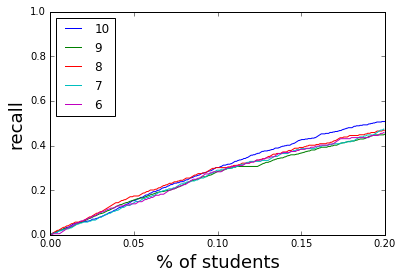

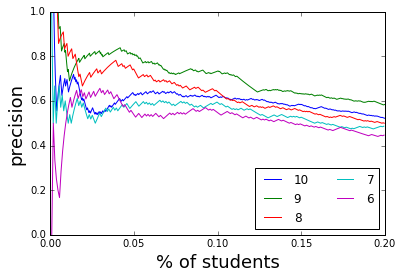

In [15]:
max_k = .2

plt.clf()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for gr in np.arange(10,5, -1):
    with open('/mnt/data/mvesc/Models_Results/pkls/'+best[gr]['RF'] + '_RF.pkl', "rb" ) as f:
        d = pickle.load(f)
    d.keys()
    scores = d['val_set_soft_preds']
    y = d['val_y']
    plot_metric(scores, y, ax1, gr, max_k, 'recall')
    plot_metric(scores, y, ax2, gr, max_k, 'precision')

plt.figure(fig1.number)
ax1.legend(loc="upper left")
ax1.set_xlabel("% of students", fontsize=18)
ax1.set_ylabel('recall', fontsize=18)
ax1.set_ylim([0,1])
ax1.set_xlim([0,max_k])
plt.savefig('meetup_results_recall_20.png')

plt.figure(fig2.number)
ax2.legend(loc="lower right", ncol=2)
ax2.set_xlabel("% of students", fontsize=18)
ax2.set_ylabel('precision', fontsize=18)
ax2.set_ylim([0,1])
ax2.set_xlim([0,max_k])
plt.savefig('meetup_results_precision_20.png')

In [ ]:
max_k = 1

plt.clf()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for gr in np.arange(10,8, -1):
    plot_metric(scores['predicted_score_{}'.format(gr)], y['true_label_{}'.format(gr)], ax1, gr, max_k, 'recall')
    plot_metric(scores['predicted_score_{}'.format(gr)], y['true_label_{}'.format(gr)], ax2, gr, max_k, 'precision')

plt.figure(fig1.number)
ax1.legend(loc="lower right")
ax1.set_xlabel("% of students", fontsize=18)
ax1.set_ylabel('recall', fontsize=18)
ax1.set_ylim([0,1])
ax1.set_xlim([0,max_k])
plt.savefig('meetup_results_recall_100.png')

plt.figure(fig2.number)
ax2.legend(loc="upper right", ncol=2)
ax2.set_xlabel("% of students", fontsize=18)
ax2.set_ylabel('precision', fontsize=18)
ax2.set_ylim([0,1])
ax2.set_xlim([0,max_k])
plt.savefig('meetup_results_precision_100.png')

# Get predictions for test/validation students in intersection of grades

In [82]:
df_list = []
grade_range = range(6,11)
with postgres_pgconnection_generator() as connection:
    for gr in grade_range:
        temp = read_table_to_df(connection, best[gr]['RF'], columns = ['student_lookup','true_label','predicted_score','split'],
                                              schema='predictions',nrows=-1)
        print(gr, temp.shape)
        temp = temp[temp['split']!='train']
        print(gr, temp.shape)
        temp.set_index('student_lookup', inplace=True)
        df_list.append(temp)
            
scores_list = [pd.DataFrame(d['predicted_score']) for d in df_list]
y_list = [pd.DataFrame(d['true_label']) for d in df_list]

for i, gr in enumerate(grade_range):
    scores_list[i].rename(columns = {'predicted_score': 'predicted_score_{0}'.format(gr)}, inplace=True)
for i, gr in enumerate(grade_range):
    y_list[i].rename(columns = {'true_label': 'true_label_{0}'.format(gr)}, inplace=True)

scores = scores_list[0]
for df in scores_list[1:]:
    scores = scores.join(df, how='inner')
y = y_list[0]
for df in y_list[1:]:
    y = y.join(df, how='inner')

6 (3186, 4)
6 (2223, 4)
7 (3414, 4)
7 (2414, 4)
8 (5948, 4)
8 (3729, 4)
9 (10466, 4)
9 (5209, 4)
10 (10782, 4)
10 (4782, 4)


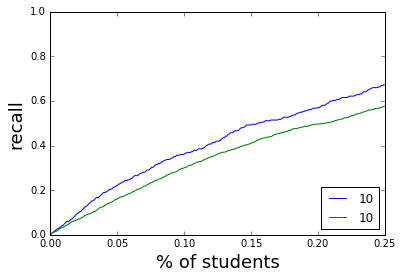

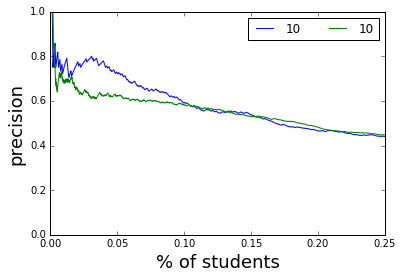

In [96]:
max_k = .25

plt.clf()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for gr in np.arange(10,11):
    plot_metric(scores['predicted_score_{}'.format(gr)], y['true_label_{}'.format(gr)], ax1, gr, max_k, 'recall')
    plot_metric(scores_list[-1]['predicted_score_{}'.format(gr)], y_list[-1]['true_label_{}'.format(gr)], ax1, gr, max_k, 'recall')
    plot_metric(scores['predicted_score_{}'.format(gr)], y['true_label_{}'.format(gr)], ax2, gr, max_k, 'precision')
    plot_metric(scores_list[-1]['predicted_score_{}'.format(gr)],  y_list[-1]['true_label_{}'.format(gr)], ax2, gr, max_k, 'precision')


plt.figure(fig1.number)
ax1.legend(loc="lower right")
ax1.set_xlabel("% of students", fontsize=18)
ax1.set_ylabel('recall', fontsize=18)
ax1.set_ylim([0,1])
ax1.set_xlim([0,max_k])
plt.savefig('recall_comparison.png')

plt.figure(fig2.number)
ax2.legend(loc="upper right", ncol=2)
ax2.set_xlabel("% of students", fontsize=18)
ax2.set_ylabel('precision', fontsize=18)
ax2.set_ylim([0,1])
ax2.set_xlim([0,max_k])
plt.savefig('precision_comparison.png')

In [105]:
print(sum(y_list[-1]['true_label_10'])/len(y_list[-1]['true_label_10']))
print(sum(y['true_label_10'])/len(y['true_label_10']))

0.194061062317
0.163655136809


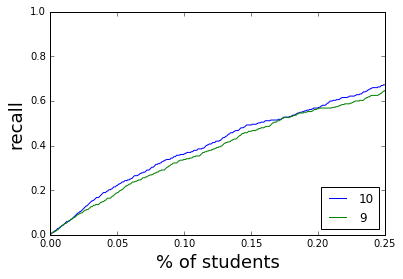

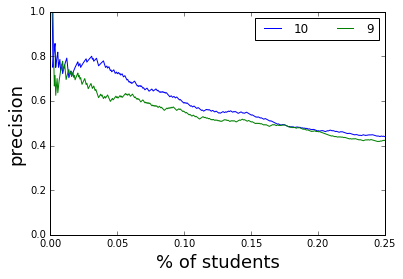

In [109]:
max_k = .25

plt.clf()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for gr in np.arange(10,8, -1):
    plot_metric(scores['predicted_score_{}'.format(gr)], y['true_label_{}'.format(gr)], ax1, gr, max_k, 'recall')
    plot_metric(scores['predicted_score_{}'.format(gr)], y['true_label_{}'.format(gr)], ax2, gr, max_k, 'precision')

plt.figure(fig1.number)
ax1.legend(loc="lower right")
ax1.set_xlabel("% of students", fontsize=18)
ax1.set_ylabel('recall', fontsize=18)
ax1.set_ylim([0,1])
ax1.set_xlim([0,max_k])
plt.savefig('meetup_results_recall_25.png')

plt.figure(fig2.number)
ax2.legend(loc="upper right", ncol=2)
ax2.set_xlabel("% of students", fontsize=18)
ax2.set_ylabel('precision', fontsize=18)
ax2.set_ylim([0,1])
ax2.set_xlim([0,max_k])
plt.savefig('meetup_results_precision_25.png')

# Student Risk Trajectories

 ...]

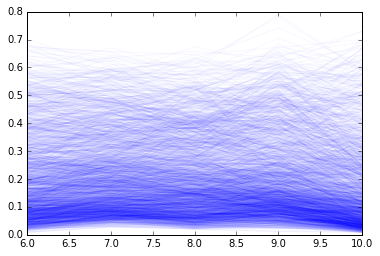

In [123]:
plt.clf()
fig1, ax1 = plt.subplots()
ax1.plot(range(6,11), scores.as_matrix().transpose(), alpha=0.03, color = 'b')


# Get predictions for students in each grade range

In [161]:
num_years = [', '.join([str(b) for b in range(a,10)]) for a in reversed(range(6,10))]
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        for gr in range(10,11):
            best = dict()
            temp = pd.DataFrame()
            for n in num_years:
                cursor.execute("""select filename from model.reports 
                            where model_name = 'RF'
                            and feature_categories =
                            'absence, demographics, grades, intervention, mobility, oaa_normalized, snapshots'
                            and prediction_grade = {}
                            and feature_grades like '{}'
                            and label = 'not_on_time'
                            order by val_precision_10 desc limit 1; """.format(gr, n))
                filename = cursor.fetchall()
                best[n] = filename[0][0]
                df = read_table_to_df(connection, best[n],
                                      ['student_lookup','true_label','predicted_score','split'],
                                      schema='predictions',nrows = -1)
                df.set_index('student_lookup',inplace=True)
                df = df[df['split'] != 'train']
                df.drop(['split'],1,inplace=True)
                df.columns = ['true_label_{}'.format(len(n.split(','))),
                              'predicted_score_{}'.format(len(n.split(',')))]
                temp = pd.concat((temp,df), axis=1, join='outer')
grade_range = temp

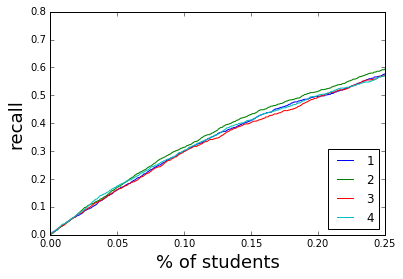

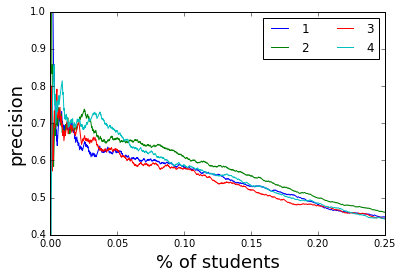

In [163]:
max_k = .25

plt.clf()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for gr in range(1,5):
    plot_metric(grade_range['predicted_score_{}'.format(gr)], grade_range['true_label_{}'.format(gr)], ax1, gr, max_k, 'recall')
    plot_metric(grade_range['predicted_score_{}'.format(gr)], grade_range['true_label_{}'.format(gr)], ax2, gr, max_k, 'precision')

plt.figure(fig1.number)
ax1.legend(loc="lower right")
ax1.set_xlabel("% of students", fontsize=18)
ax1.set_ylabel('recall', fontsize=18)
ax1.set_ylim([0,.8])
ax1.set_xlim([0,max_k])
plt.savefig('grade_10_recall_25.png')

plt.figure(fig2.number)
ax2.legend(loc="upper right", ncol=2)
ax2.set_xlabel("% of students", fontsize=18)
ax2.set_ylabel('precision', fontsize=18)
ax2.set_ylim([.4,1])
ax2.set_xlim([0,max_k])
plt.savefig('grade_10_precision_25.png')

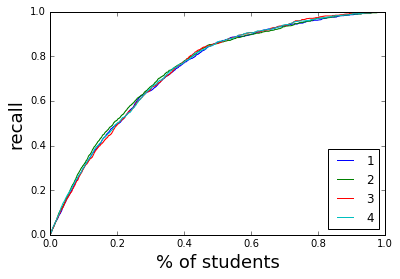

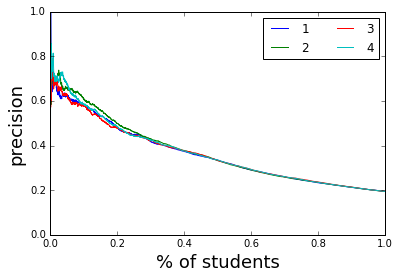

In [164]:
max_k = 1

plt.clf()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for gr in range(1,5):
    plot_metric(grade_range['predicted_score_{}'.format(gr)], grade_range['true_label_{}'.format(gr)], ax1, gr, max_k, 'recall')
    plot_metric(grade_range['predicted_score_{}'.format(gr)], grade_range['true_label_{}'.format(gr)], ax2, gr, max_k, 'precision')

plt.figure(fig1.number)
ax1.legend(loc="lower right")
ax1.set_xlabel("% of students", fontsize=18)
ax1.set_ylabel('recall', fontsize=18)
ax1.set_ylim([0,1])
ax1.set_xlim([0,max_k])
plt.savefig('grade_10_recall_100.png')

plt.figure(fig2.number)
ax2.legend(loc="upper right", ncol=2)
ax2.set_xlabel("% of students", fontsize=18)
ax2.set_ylabel('precision', fontsize=18)
ax2.set_ylim([0,1])
ax2.set_xlim([0,max_k])
plt.savefig('grade_10_precision_100.png')